# Random Forest
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

In [19]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data


current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "abomination-vaults-bestiary.db",
    "age-of-ashes-bestiary.db",
    "agents-of-edgewatch-bestiary.db",
    "april-fools-bestiary.db",
    "blog-bestiary.db",
    "blood-lords-bestiary.db",
    "book-of-the-dead-bestiary.db",
    "crown-of-the-kobold-king-bestiary.db",
    "extinction-curse-bestiary.db",
    "fall-of-plaguestone.db",
    "fists-of-the-ruby-phoenix-bestiary.db",
    "gatewalkers-bestiary.db",
    "impossible-lands-bestiary.db",
    "kingmaker-bestiary.db",
    "malevolence-bestiary.db",
    "menace-under-otari-bestiary.db",
    "monsters-of-myth-bestiary.db",
    "mwangi-expanse-bestiary.db",
    "night-of-the-gray-death-bestiary.db",
    "npc-gallery.db",
    "one-shot-bestiary.db",
    "outlaws-of-alkenstar-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
    "pathfinder-bestiary.db",
    "pathfinder-dark-archive.db",
    "pfs-introductions-bestiary.db",
    "pfs-season-1-bestiary.db",
    "pfs-season-2-bestiary.db",
    "pfs-season-3-bestiary.db",
    "pfs-season-4-bestiary.db",
    "quest-for-the-frozen-flame-bestiary.db",
    "shadows-at-sundown-bestiary.db",
    "strength-of-thousands-bestiary.db",
    "the-slithering-bestiary.db",
    "travel-guide-bestiary.db",
    "troubles-in-otari-bestiary.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   str     3690 non-null   float64
 1   dex     3690 non-null   float64
 2   level   3690 non-null   int64  
 3   con     3690 non-null   float64
 4   hp      3690 non-null   int32  
 5   wis     3690 non-null   float64
 6   book    3690 non-null   object 
 7   ac      3690 non-null   float64
 8   cha     3690 non-null   float64
 9   int     3690 non-null   float64
dtypes: float64(7), int32(1), int64(1), object(1)
memory usage: 302.7+ KB


In [21]:
df.head()

,str,dex,level,con,hp,wis,book,ac,cha,int
0,6.0,3.0,9,0.0,155,3.0,Pathfinder #165: Eyes of Empty Death,28.0,0.0,0.0
1,7.0,3.0,10,6.0,175,3.0,Pathfinder Abomination Vaults Hardcover Compil...,30.0,0.0,0.0
2,4.0,3.0,2,1.0,38,3.0,Pathfinder #164: Hands of the Devil,17.0,1.0,-2.0
3,3.0,4.0,8,3.0,140,3.0,Pathfinder #164: Hands of the Devil,27.0,1.0,0.0
4,-5.0,6.0,9,0.0,90,4.0,Pathfinder #165: Eyes of Empty Death,31.0,2.0,2.0


## Train test split

### Chronological split

In [22]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/random_forest")

In [23]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [24]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [25]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [26]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

### With chronological split

In [27]:
from sklearn.ensemble import RandomForestRegressor


rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [28]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 1.62
MAE: 1.27


In [30]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "basic", rmse, mae]

###### MAE by level

In [31]:
from training.results import plot_mae_by_level

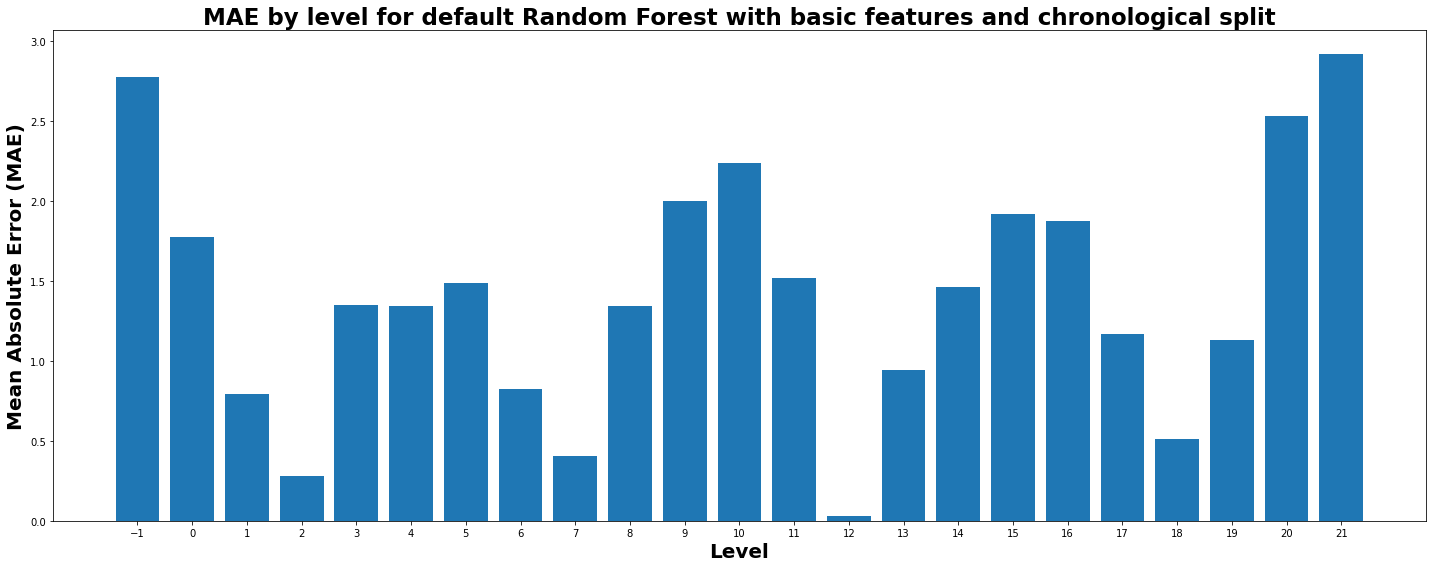

In [32]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default Random Forest with basic features and chronological split",
)

In [33]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 1.62

Round type: 0.5
RMSE: 1.65

Round type: 0.33
RMSE: 1.66

Round type: 0.45
RMSE: 1.65



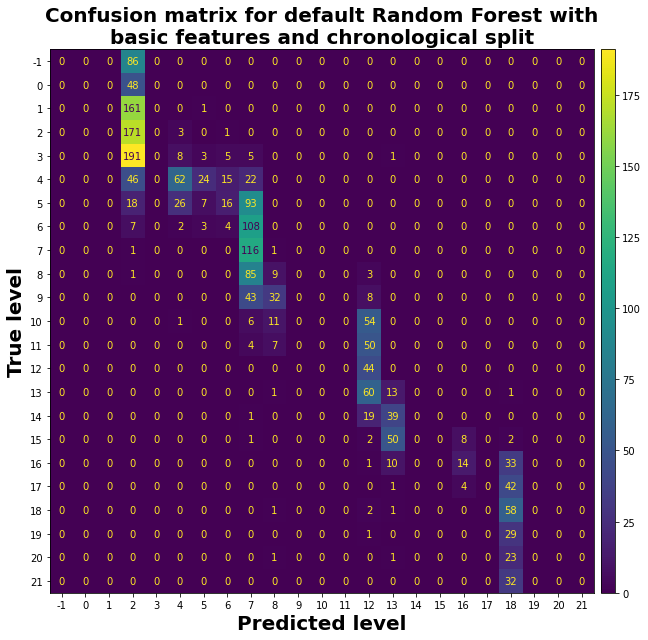

In [34]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default Random Forest with\nbasic features and chronological split",
)

#### Tuning

In [35]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [36]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.6s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.3s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.2s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.2s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.3s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   1.5s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   1.6s
[CV] END .max_depth=None, max_features=0.1, n_

[CV] END ...max_depth=30, max_features=0.1, n_estimators=800; total time=   1.8s
[CV] END ...max_depth=30, max_features=0.2, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=30, max_features=0.2, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=30, max_features=0.2, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.4, n_estimators=600; total time=   1.6s
[CV] END ...max_depth=20, max_features=0.4, n_estimators=600; total time=   1.7s
[CV] END ...max_depth=20, max_features=0.4, n_estimators=600; total time=   1.3s
[CV] END ...max_depth=20, max_features=0.1, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.1, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.1, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=60, max_features=0.05, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=60, max_features=0.05, n_estimators=200; total time=   0.5s
[CV] END ..max_depth=60, max

[CV] END ...max_depth=60, max_features=0.1, n_estimators=500; total time=   1.0s
[CV] END .max_depth=20, max_features=0.025, n_estimators=500; total time=   1.0s
[CV] END .max_depth=20, max_features=0.025, n_estimators=500; total time=   1.3s
[CV] END .max_depth=20, max_features=0.025, n_estimators=500; total time=   1.3s
[CV] END ...max_depth=30, max_features=0.1, n_estimators=600; total time=   1.4s
[CV] END ...max_depth=30, max_features=0.1, n_estimators=600; total time=   1.5s
[CV] END ...max_depth=30, max_features=0.1, n_estimators=600; total time=   1.4s
[CV] END ...max_depth=10, max_features=0.2, n_estimators=700; total time=   1.6s
[CV] END ...max_depth=10, max_features=0.2, n_estimators=700; total time=   2.1s
[CV] END ...max_depth=10, max_features=0.2, n_estimators=700; total time=   1.4s
[CV] END ..max_depth=20, max_features=0.05, n_estimators=600; total time=   1.7s
[CV] END ..max_depth=20, max_features=0.05, n_estimators=600; total time=   1.3s
[CV] END ..max_depth=20, max

{'n_estimators': 400, 'max_features': 0.5, 'max_depth': 50}

In [37]:
y_pred_test = rf_random.predict(X_test)

In [38]:
from training.results import assess_regression_model


rmse, mae = assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.19
RMSE test: 0.75
MAE test: 0.42



In [39]:
results.loc[1] = [
    "chronological",
    "RandomizedSearchCV",
    "basic",
    rmse,
    mae,
]

###### MAE by level

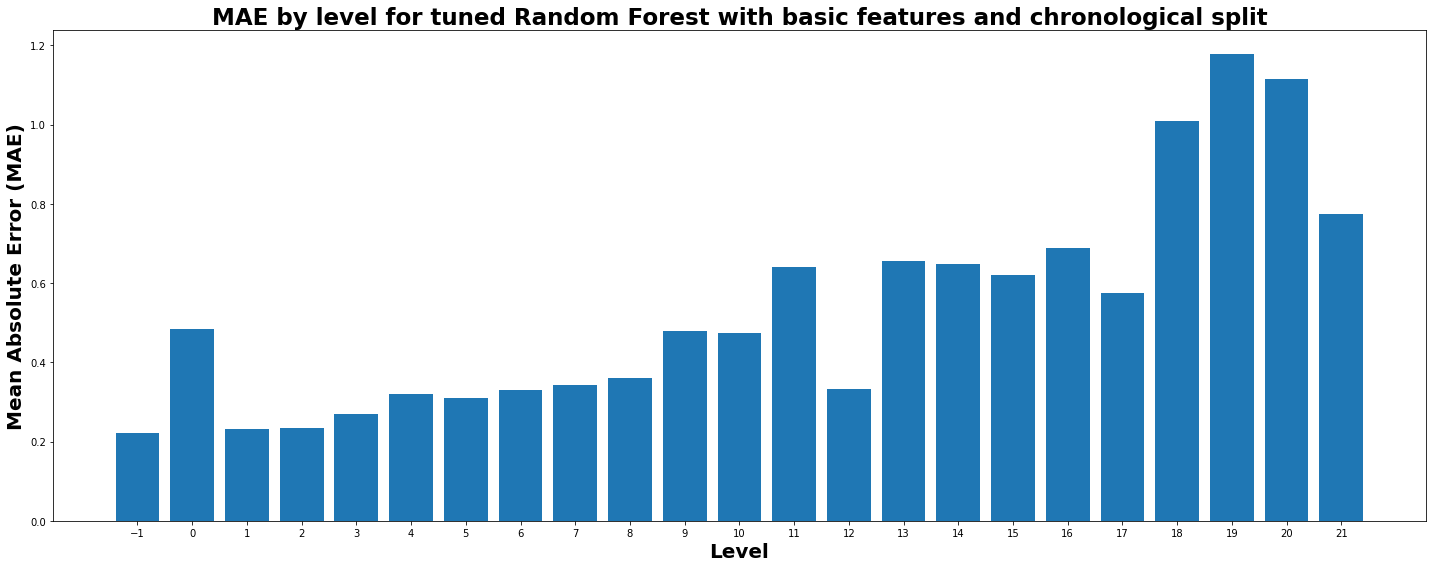

In [40]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned Random Forest with basic features and chronological split",
)

In [41]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.75

Round type: 0.5
RMSE: 0.78

Round type: 0.33
RMSE: 0.75

Round type: 0.45
RMSE: 0.77



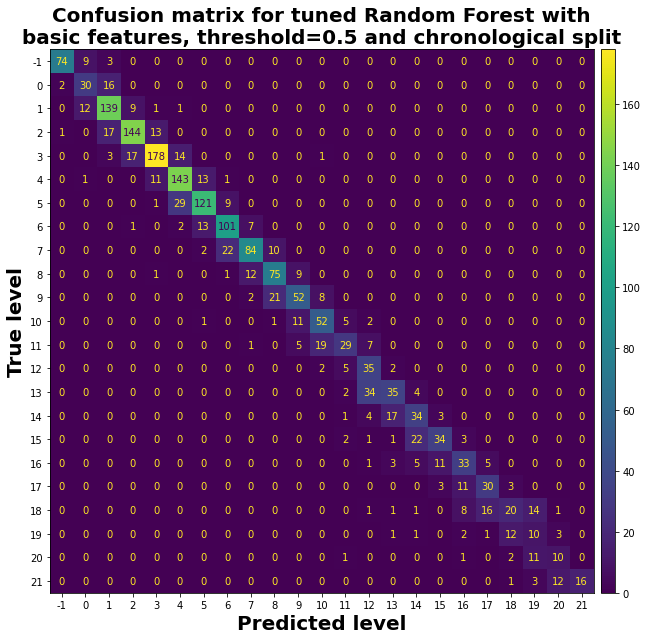

In [42]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for tuned Random Forest with\nbasic features, threshold=0.5 and chronological split",
)

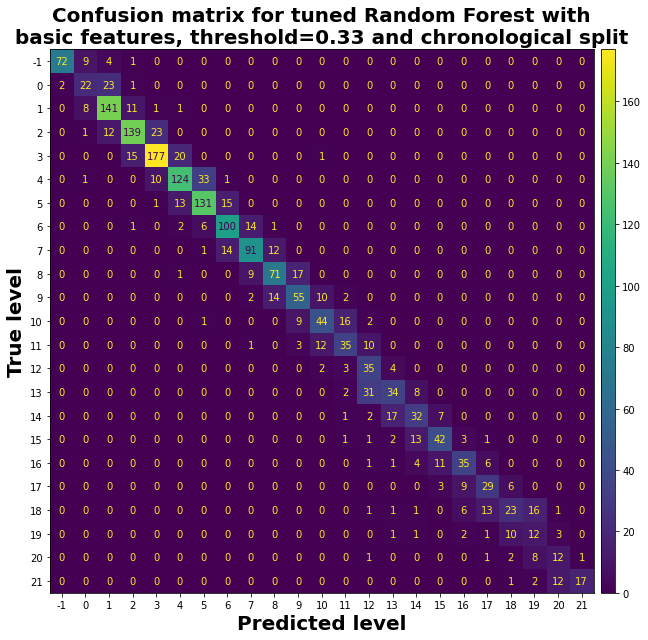

In [43]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    0.33,
    title="Confusion matrix for tuned Random Forest with\nbasic features, threshold=0.33 and chronological split",
)

### Random split

In [44]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [45]:
y_pred_train_random_split = rf_reg.predict(X_train_random_split)
y_pred_test_random_split = rf_reg.predict(X_test_random_split)

In [46]:
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test_random_split)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 1.55
MAE: 1.24


In [47]:
results.loc[3] = ["random", "default", "basic", rmse, mae]

###### MAE by level

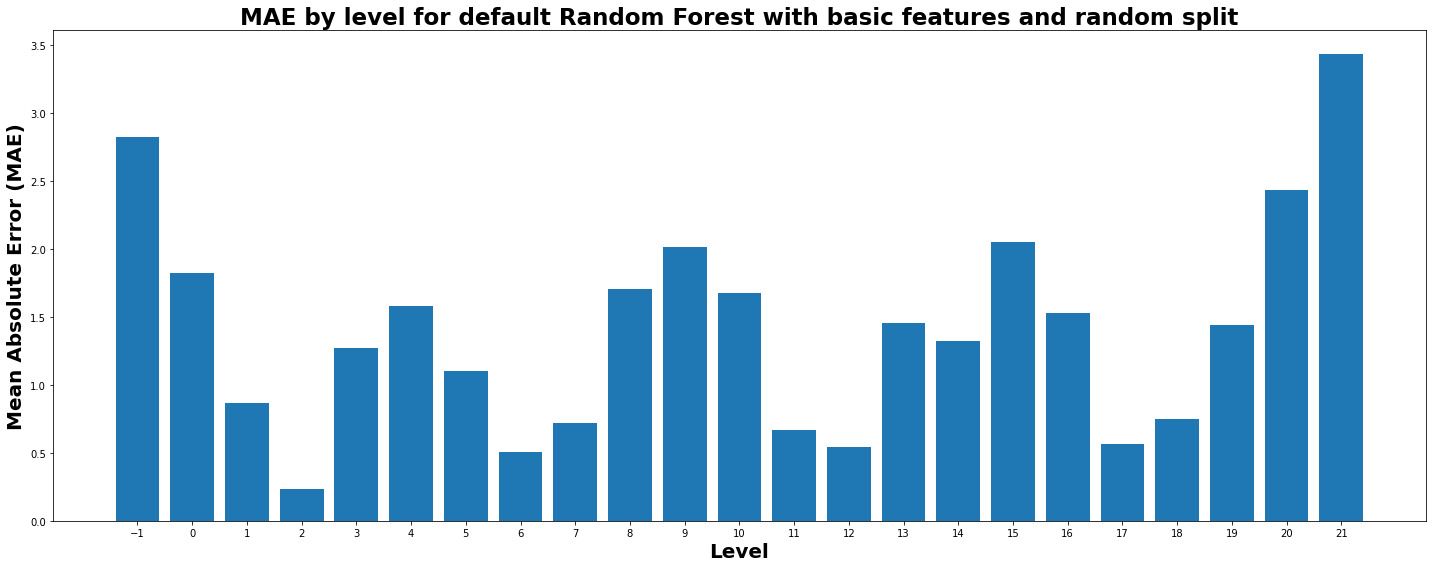

In [48]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for default Random Forest with basic features and random split",
)

In [49]:
evaluate_round_predictions(
    [0.5, 0.33, 0.45], y_test_random_split, y_pred_test_random_split
)

Default:
RMSE: 1.55

Round type: 0.5
RMSE: 1.60

Round type: 0.33
RMSE: 1.53

Round type: 0.45
RMSE: 1.61



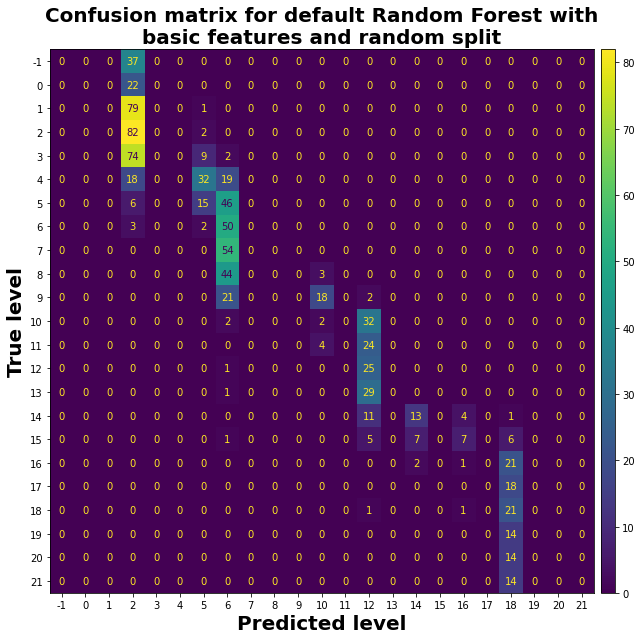

In [50]:
plot_confusion_matrix(
    y_pred_test_random_split,
    y_test_random_split,
    title="Confusion matrix for default Random Forest with\nbasic features and random split",
)

#### Tuning

In [51]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [52]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.6s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.8s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.9s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   2.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.9s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.7s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.9s
[CV] END ...max_depth=70, max_features=0.5, n_

[CV] END ..max_depth=110, max_features=0.4, n_estimators=700; total time=   2.4s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   1.2s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.9s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.4s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   2.3s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.2s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.2s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   2.4s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   2.1s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   2.3s
[CV] END ...max_depth=50, ma

[CV] END ...max_depth=20, max_features=0.4, n_estimators=500; total time=   1.8s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.3s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   2.5s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   1.5s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   1.9s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   3.3s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   3.4s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   2.7s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   3.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   3.4s
[CV] END ...max_depth=20, ma

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [53]:
y_pred_test_random_split = rf_random.predict(X_test_random_split)

In [54]:
rmse, mae = assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.22
RMSE test: 0.53
MAE test: 0.32



In [55]:
results.loc[4] = ["random", "RandomizedSearchCV", "basic", rmse, mae]

###### MAE by level

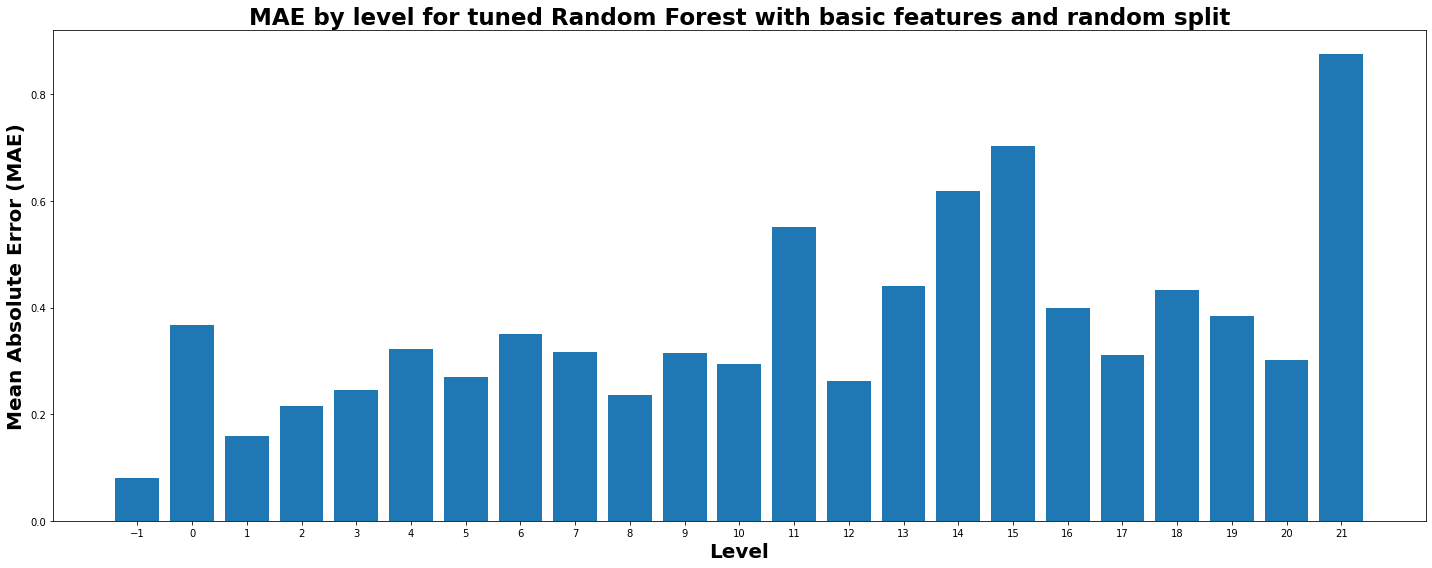

In [56]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for tuned Random Forest with basic features and random split",
)

In [57]:
evaluate_round_predictions(
    [0.5, 0.33, 0.45], y_test_random_split, y_pred_test_random_split
)

Default:
RMSE: 0.53

Round type: 0.5
RMSE: 0.57

Round type: 0.33
RMSE: 0.59

Round type: 0.45
RMSE: 0.57



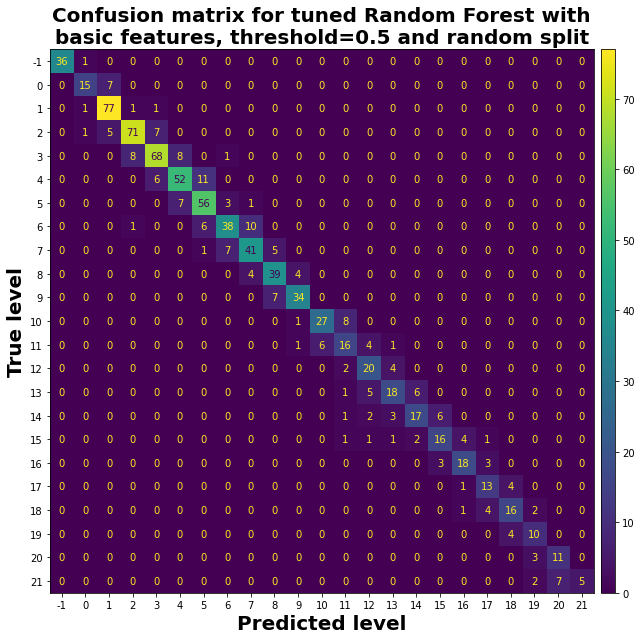

In [58]:
plot_confusion_matrix(
    y_pred_test_random_split,
    y_test_random_split,
    title="Confusion matrix for tuned Random Forest with\nbasic features, threshold=0.5 and random split",
    export=True,
)

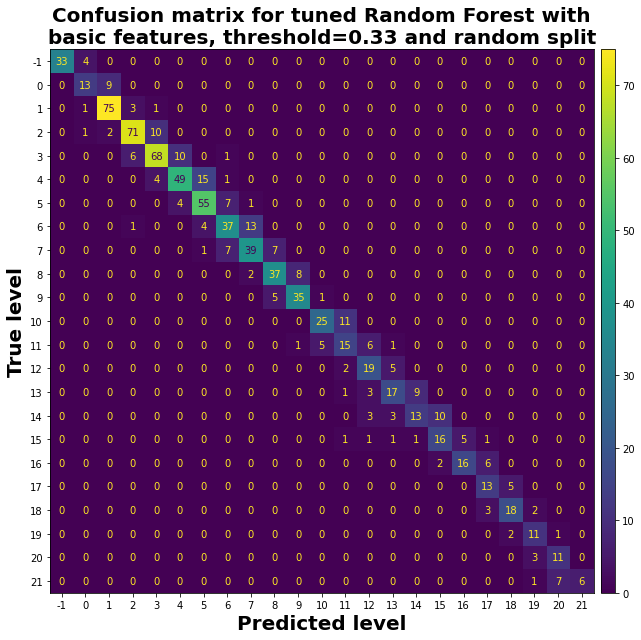

In [59]:
plot_confusion_matrix(
    y_pred_test_random_split,
    y_test_random_split,
    0.33,
    title="Confusion matrix for tuned Random Forest with\nbasic features, threshold=0.33 and random split",
)

## Summary

In [60]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,basic,1.624714,1.269617
1,chronological,RandomizedSearchCV,basic,0.745809,0.421731
3,random,default,basic,1.547770,1.244916
4,random,RandomizedSearchCV,basic,0.531456,0.317028


In [61]:
from training.results import plot_summary

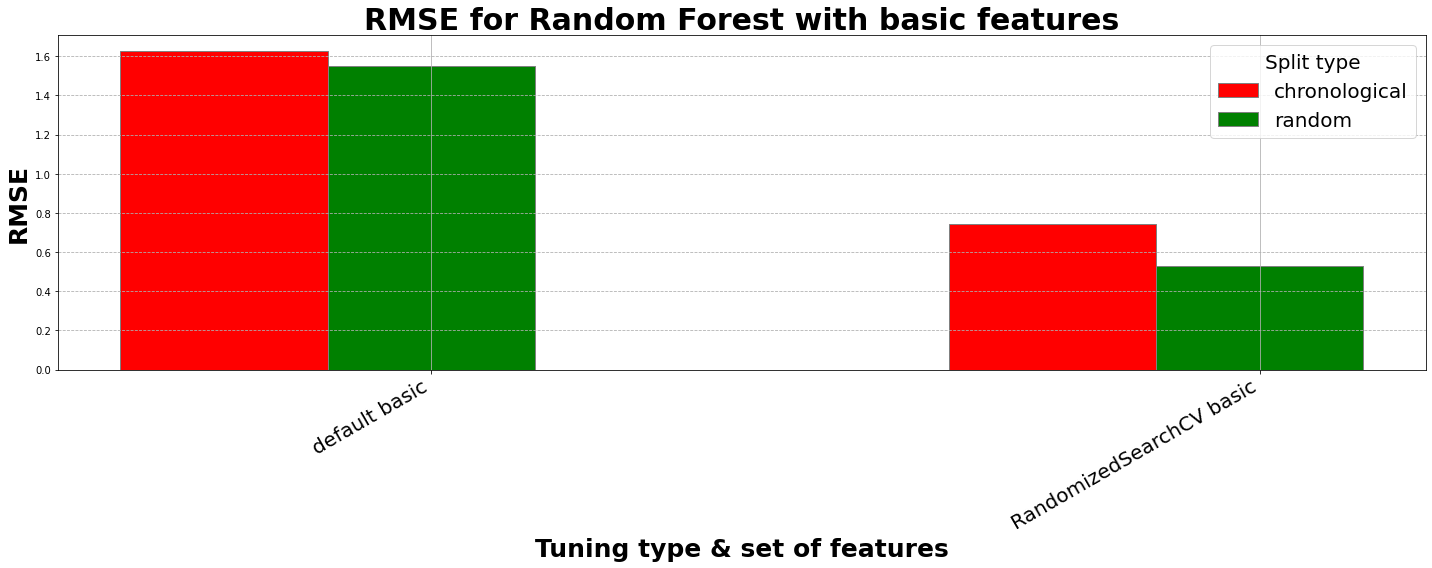

In [62]:
plot_summary(results, "RMSE", title="RMSE for Random Forest with basic features")

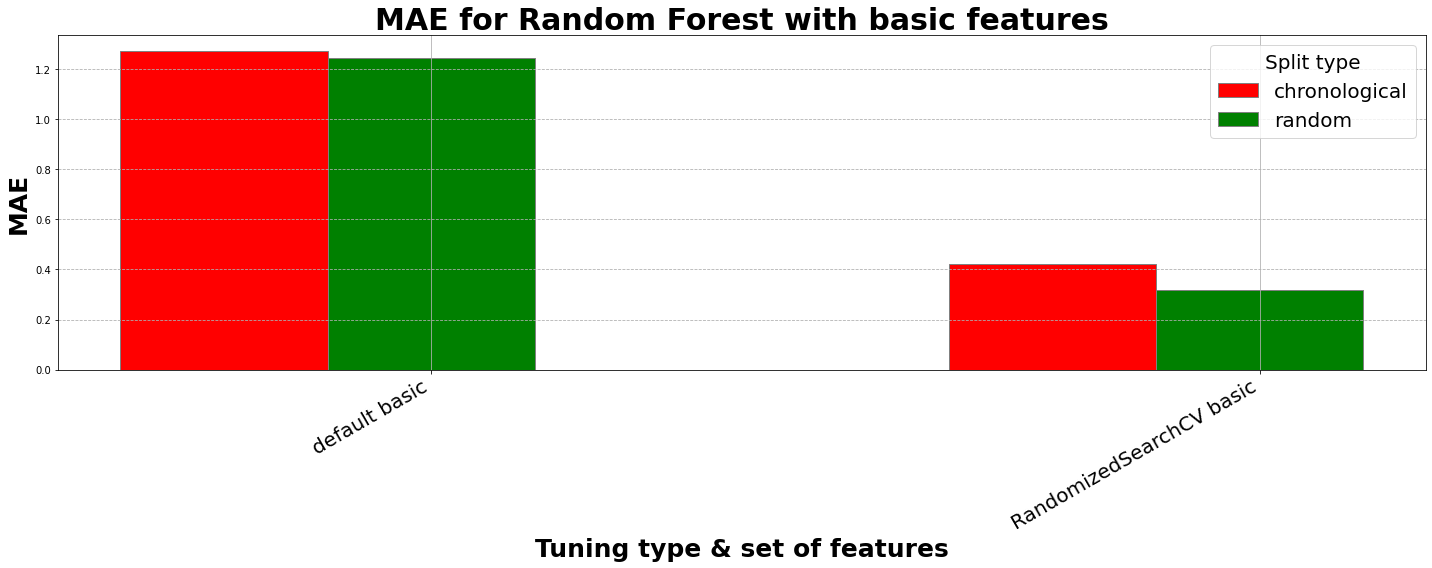

In [63]:
plot_summary(results, "MAE", title="MAE for Random Forest with basic features")

In [64]:
results.to_csv("./random_forest_basic_results.csv")